In [18]:
##Plotting settings 
import matplotlib.pyplot as pp
# Example of matplotlib settings using latex rendering etc
fig_width_pt  = 245.27 #513.17              # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27                   # Convert pt to inches
golden_mean   = (np.sqrt(5)-1.0)/2.0        # Aesthetic ratio
fig_width     = fig_width_pt*inches_per_pt  # width in inches
fig_height    = fig_width*golden_mean       # height in inches
fig_size      = [fig_width,fig_height]

params = {'backend': 'pdf',
        'axes.labelsize': 8,
        'lines.markersize': 4,
        'font.size': 14,
        'xtick.major.size':6,
        'xtick.minor.size':5,  
        'ytick.major.size':6,
        'ytick.minor.size':5, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 8,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.sans-serif': ['Bitstream Vera Sans'],
        'font.serif': ['Times New Roman'],
        'text.latex.preamble': r'\usepackage{amsmath}',
        'text.usetex':True}

pp.rcParams.update(params)

#%matplotlib inline
pp.rcParams['figure.dpi'] = 150
#%config InlineBackend.figure_format = 'retina'

# Specify some aesthetic colours
dodgerblue      = '#1E90FF'
princetonorange = '#ff8f00'
tanzaniagreen   = '#1eb53a'

In [2]:
import os
import time
import pkg_resources
import math
import types
import torch
import torch.optim as optim
from scipy import constants
from scipy import integrate
import scipy.stats as stats
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy.special as scs
from ringdown import h_t
from sinc import h_func_mt


def rescale(x, y, region):
    '''takes normalised parameter regions and 
    rescales them for plotting'''
    xs = region[0][0] + x * (region[0][1] - region[0][0])
    ys = region[1][0] + y * (region[1][1] - region[1][0])
    return xs, ys

def numpy2cuda(array, single=True):
    array = torch.from_numpy(array)
  
    if single:
        array = array.float()
    
    if torch.cuda.is_available():
        array = array.cuda()
    
    return array

def cuda2numpy(tensor):
    return tensor.detach().cpu().numpy()

#Geometry.py
def setgeometry(q):
    global qdim, xmin, xmax, xstops, xmid, xwid

    # bins
    qdim = q

    # prior range for x (will be uniform)
    xmin, xmax = 0, 1

    # definition of quantization bins
    xstops = np.linspace(xmin, xmax, qdim + 1)

    # to plot histograms
    xmid = 0.5 * (xstops[:-1] + xstops[1:])
    xwid = xstops[1] - xstops[0]

setgeometry(64)

#Network.py
def makenet(dims, softmax=True, single=True):
  """Make a fully connected DNN with layer widths described by `dims`.
  CUDA is always enabled, and double precision is set with `single=False`.
  The output layer applies a softmax transformation,
  disabled by setting `softmax=False`."""

  ndims = len(dims)

  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # the weights must be set explicitly as attributes in the class
      # (i.e., we can't collect them in a single list)
      for l in range(ndims - 1):
        layer = nn.Linear(dims[l], dims[l+1])
        
        if not single:
          layer = layer.double()
        
        if torch.cuda.is_available():
          layer = layer.cuda()
        
        setattr(self, f'fc{l}', layer)
                
    def forward(self, x):
      # per Alvin's recipe, apply relu everywhere but last layer
      for l in range(ndims - 2):
        x = F.leaky_relu(getattr(self, f'fc{l}')(x), negative_slope=0.2)

      x = getattr(self, f'fc{ndims - 2}')(x)

      if softmax:
        return F.softmax(x, dim=1)
      else:
        return x
  
  return Net


def makenetbn(dims, softmax=True, single=True):
  """A batch-normalizing version of makenet. Experimental."""

  ndims = len(dims)

  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # the weights must be set explicitly as attributes in the class
      # (i.e., we can't collect them in a single list)
      for l in range(ndims - 1):
        layer = nn.Linear(dims[l], dims[l+1])
        bn = nn.BatchNorm1d(num_features=dims[l+1])
        
        if not single:
          layer = layer.double()
          bn = bn.double()
        
        if torch.cuda.is_available():
          layer = layer.cuda()
          bn = bn.cuda()
        
        setattr(self, f'fc{l}', layer)
        setattr(self, f'bn{l}', bn)
                
    def forward(self, x):
      # per Alvin's recipe, apply relu everywhere but last layer
      for l in range(ndims - 2):
        x = getattr(self, f'bn{l}')(F.leaky_relu(getattr(self, f'fc{l}')(x), negative_slope=0.2))

      x = getattr(self, f'fc{ndims - 2}')(x)

      if softmax:
        return F.softmax(x, dim=1)
      else:
        return x
  
  return Net

#Loss function - Kullback-Libeler.
def kllossGn2(o, l: 'xtrue'):
  """KL loss for Gaussian-mixture output, 2D, precision-matrix parameters."""

  dx  = o[:,0::6] - l[:,0,np.newaxis]
  dy  = o[:,2::6] - l[:,1,np.newaxis]
  
  # precision matrix is positive definite, so has positive diagonal terms
  Fxx = o[:,1::6]**2
  Fyy = o[:,3::6]**2
  
  # precision matrix is positive definite, so has positive 
  Fxy = torch.atan(o[:,4::6]) / (0.5*math.pi) * o[:,1::6] * o[:,3::6]
  
  weight = torch.softmax(o[:,5::6], dim=1)
   
  # omitting the sqrt(4*math*pi) since it's common to all templates
  return -torch.mean(torch.logsumexp(torch.log(weight) - 0.5*(Fxx*dx*dx + Fyy*dy*dy + 2*Fxy*dx*dy) + 0.5*torch.log(Fxx*Fyy - Fxy*Fxy), dim=1))



In [3]:
def syntrain(size,  region, varx=['Mc', 'tc'], 
             varall=True, seed=None, single=True, noise=0):
    """Makes a training set using the ROMAN NN. It returns labels (for `varx`,
        or for all if `varall=True`), indicator vectors, and ROM coefficients
        (with `snr` and `noise`). Note that the coefficients are kept on the GPU.
        Parameters are sampled randomly within `region`."""
    #device = dev
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu:0'
    
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)
    
    with torch.no_grad():
        xs = torch.zeros((size, len(region)), dtype=torch.float, device=device)

        for i, r in enumerate(region):
            xs[:,i] = r[0] + (r[1] - r[0]) * torch.rand((size,), dtype=torch.float, device=device)
        
        xs_1 = xs.detach().cpu().double().numpy()
        
        #generating signals
        signal = np.apply_along_axis(h_func_mt, 1, xs_1)[:,:]
            
        signal_r, signal_i = numpy2cuda(signal.real), 0 #set to 0 as we dont need imaginary part
        
        #setting up real alphas
        alphas = torch.zeros((size, 200), dtype=torch.float if single else torch.double, device=device)

        norm = torch.sqrt(torch.sum(signal_r*signal_r + signal_i*signal_i, dim=1))
        
        #add random signal amplitudes #snr
        A = [8,12]
        const = numpy2cuda(np.random.uniform(*A, size=size))

        #add noise to the signal and normalise
        alphas[:,:] = const[:, np.newaxis]*signal_r/norm[:, np.newaxis] + (noise*torch.randn((size, 200), device=device))


    xr = np.zeros((size, len(region)), 'd')
    xr = xs.detach().cpu().double().numpy()
    del xs, signal_r, signal_i

    for i, r in enumerate(region):
        xr[:,i] = (xr[:,i] - r[0]) / (r[1] - r[0])

    if isinstance(varx, list):
        ix = ['Mc','tc'].index(varx[0])
        jx = ['Mc','tc'].index(varx[1])    

        i = np.digitize(xr[:,ix], xstops, False) - 1
        i[i == -1] = 0; i[i == qdim] = qdim - 1
        px = np.zeros((size, qdim), 'd'); px[range(size), i] = 1

        j = np.digitize(xr[:,jx], xstops, False) - 1
        j[j == -1] = 0; j[j == qdim] = qdim - 1
        py = np.zeros((size, qdim), 'd'); py[range(size), j] = 1

        if varall:
            return xr, np.einsum('ij,ik->ijk', px, py), alphas
        else:
            return xr[:,[ix,jx]], np.einsum('ij,ik->ijk', px, py), alphas    
    else:
        ix = ['Mc','tc'].index(varx)

        i = np.digitize(xr[:,ix], xstops, False) - 1
        i[i == -1] = 0; i[i == qdim] = qdim - 1
        px = np.zeros((size, qdim), 'd'); px[range(size), i] = 1

        if varall:
            return xr, px, alphas
        else:
            return xr[:,ix], px, alphas

def syntrain_RD(size,  region, varx=['a', 'M'], 
             varall=True, seed=None, single=True, noise=0):
    """Makes a training set using the ROMAN NN. It returns labels (for `varx`,
        or for all if `varall=True`), indicator vectors, and ROM coefficients
        (with `snr` and `noise`). Note that the coefficients are kept on the GPU.
        Parameters are sampled randomly within `region`."""
    #device = dev
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu:0'
    
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)
    
    with torch.no_grad():
        xs = torch.zeros((size, len(region)), dtype=torch.float, device=device)

        for i, r in enumerate(region):
            xs[:,i] = r[0] + (r[1] - r[0]) * torch.rand((size,), dtype=torch.float, device=device)
        
        xs_1 = xs.detach().cpu().double().numpy()
        
        #generating signals
        signal = np.apply_along_axis(h_t, 1, xs_1)[:,:]
            
        signal_r, signal_i = numpy2cuda(signal.real), 0 #set to 0 as we dont need imaginary part
        
        #setting up real alphas
        alphas = torch.zeros((size, 200), dtype=torch.float if single else torch.double, device=device)

        norm = torch.sqrt(torch.sum(signal_r*signal_r + signal_i*signal_i, dim=1))
        
        # add random signal amplitudes 
        A = [80, 100] #snr
        const = numpy2cuda(np.random.uniform(*A, size=size))

        ###signal already normalised
        alphas[:,:] = const[:, np.newaxis]*signal_r/norm[:, np.newaxis] + (noise*torch.randn((size, 200), device=device))


    xr = np.zeros((size, len(region)), 'd')
    xr = xs.detach().cpu().double().numpy()
    del xs, signal_r, signal_i

    for i, r in enumerate(region):
        xr[:,i] = (xr[:,i] - r[0]) / (r[1] - r[0])

    if isinstance(varx, list):
        ix = ['a','M'].index(varx[0])
        jx = ['a','M'].index(varx[1])    

        i = np.digitize(xr[:,ix], xstops, False) - 1
        i[i == -1] = 0; i[i == qdim] = qdim - 1
        px = np.zeros((size, qdim), 'd'); px[range(size), i] = 1

        j = np.digitize(xr[:,jx], xstops, False) - 1
        j[j == -1] = 0; j[j == qdim] = qdim - 1
        py = np.zeros((size, qdim), 'd'); py[range(size), j] = 1

        if varall:
            return xr, np.einsum('ij,ik->ijk', px, py), alphas
        else:
            return xr[:,[ix,jx]], np.einsum('ij,ik->ijk', px, py), alphas    
    else:
        ix = ['a','M'].index(varx)

        i = np.digitize(xr[:,ix], xstops, False) - 1
        i[i == -1] = 0; i[i == qdim] = qdim - 1
        px = np.zeros((size, qdim), 'd'); px[range(size), i] = 1

        if varall:
            return xr, px, alphas
        else:
            return xr[:,ix], px, alphas

In [4]:
def netmeanGn2(inputs, net=None, single=True):
  if isinstance(inputs, np.ndarray):
    inputs = numpy2cuda(inputs, single)
    
  pars = cuda2numpy(net(inputs))

  dx, dy = pars[:,0::6], pars[:,2::6] 
  
  Fxx, Fyy = pars[:,1::6]**2, pars[:,3::6]**2
  Fxy = np.arctan(pars[:,4::6]) / (0.5*math.pi) * pars[:,1::6] * pars[:,3::6]

  det = Fxx*Fyy - Fxy*Fxy
  Cxx, Cyy, Cxy = Fyy/det, Fxx/det, -Fxy/det

  pweight = torch.softmax(torch.from_numpy(pars[:,5::6]),dim=1).numpy()

  xmean, ymean = np.sum(pweight * dx, axis=1), np.sum(pweight * dy, axis=1)
  xerr,  yerr  = np.sqrt(np.sum(pweight * (dx**2 + Cxx), axis=1) - xmean**2), np.sqrt(np.sum(pweight * (dy**2 + Cyy), axis=1) - ymean**2) 
  xycov        = np.sum(pweight * (dx*dy + Cxy), axis=1) - xmean*ymean

  return np.vstack((xmean, ymean)).T, np.vstack((xerr, yerr)).T, xycov

def synmean(a, syntrain, iterations=1000000):
  with torch.no_grad():
    # note aimag defined with plus here, exp below modified consistently
    # [areal] = [aimag] = nbasis x nsignals 
    areal, aimag = torch.t(a[:,0::2]), torch.t(a[:,1::2])

    # [anorm] = nsignals
    anorm = torch.sum(areal*areal + aimag*aimag, dim=0)
    
    cnt = 0
    mean, square, cov, norm = 0.0, 0.0, 0.0, 0.0
    adapt = None
    while cnt < iterations:
      # [x] = nbatch
      x, _, alpha = syntrain()
      cnt = cnt + alpha.shape[0]

      x = numpy2cuda(x, alpha.dtype == torch.float32)
              
      # [alphareal] = [alphaimag] = nbatch x nbasis
      alphareal, alphaimag = alpha[:,0::2], alpha[:,1::2]
      
      # [alphanorm] = nbatch
      alphanorm = torch.sum(alphareal*alphareal + alphaimag*alphaimag, dim=1)

      # [like] = nbatch x nsignals = [(nbatch x nbasis) @ (nbasis x nsignals) + (nbatch x 1) + nsignals]
      # like = alphareal @ areal + alphaimag @ aimag - 0.5*alphanorm.unsqueeze(1) - 0.5*anorm
      like = alphareal @ areal
      like += alphaimag @ aimag
      like -= 0.5*alphanorm.unsqueeze(1)
      like -= 0.5*anorm

      if adapt is None:
        adapt = torch.max(like, dim=0)[0]
      
      like -= adapt
      like = torch.exp_(like) # in-place operation

      # [mean] = nsignals = nbatch @ (nbatch x nsignals)
      # in the 2D case, 2 x nsignals = 2 x nbatch @ (nbatch x nsignals)
      mean += torch.t(x) @ like
      square += (torch.t(x)**2) @ like
      
      if x.dim() == 2:
        cov += (x[:,0] * x[:,1]) @ like

      # [norm] = nsignals
      norm += torch.sum(like, dim=0)

      # note this tensor is very large (iter x len(a)); we should get rid of it asap        
      del like
    
    # naive variance algorithm, hope for best, see also
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance
    
    # [ret] = nsignals
    retmean = mean / norm
    reterr = torch.sqrt(square / norm - retmean * retmean)
    
    if x.dim() == 1:
      return cuda2numpy(retmean).T, cuda2numpy(reterr).T
    else:
      retcov = cov / norm - retmean[0,:]*retmean[1,:]
      return cuda2numpy(retmean).T, cuda2numpy(reterr).T, cuda2numpy(retcov)
    
def synmean_RD(a, syntrain, size=10000, region=None, iterations=1000000):
  with torch.no_grad():
    # note aimag defined with plus here, exp below modified consistently
    # [areal] = [aimag] = nbasis x nsignals 
    areal, aimag = torch.t(a[:,0::2]), torch.t(a[:,1::2])

    # [anorm] = nsignals
    anorm = torch.sum(areal*areal + aimag*aimag, dim=0)
    
    cnt = 0
    mean, square, cov, norm = 0.0, 0.0, 0.0, 0.0
    adapt = None
    while cnt < iterations:
      # [x] = nbatch
      x, _, alpha = syntrain_RD(size, region)
      cnt = cnt + alpha.shape[0]

      x = numpy2cuda(x, alpha.dtype == torch.float32)
              
      # [alphareal] = [alphaimag] = nbatch x nbasis
      alphareal, alphaimag = alpha[:,0::2], alpha[:,1::2]
      
      # [alphanorm] = nbatch
      alphanorm = torch.sum(alphareal*alphareal + alphaimag*alphaimag, dim=1)

      # [like] = nbatch x nsignals = [(nbatch x nbasis) @ (nbasis x nsignals) + (nbatch x 1) + nsignals]
      # like = alphareal @ areal + alphaimag @ aimag - 0.5*alphanorm.unsqueeze(1) - 0.5*anorm
      like = alphareal @ areal
      like += alphaimag @ aimag
      like -= 0.5*alphanorm.unsqueeze(1)
      like -= 0.5*anorm

      if adapt is None:
        adapt = torch.max(like, dim=0)[0]
      
      like -= adapt
      like = torch.exp_(like) # in-place operation

      # [mean] = nsignals = nbatch @ (nbatch x nsignals)
      # in the 2D case, 2 x nsignals = 2 x nbatch @ (nbatch x nsignals)
      mean += torch.t(x) @ like
      square += (torch.t(x)**2) @ like
      
      if x.dim() == 2:
        cov += (x[:,0] * x[:,1]) @ like

      # [norm] = nsignals
      norm += torch.sum(like, dim=0)

      # note this tensor is very large (iter x len(a)); we should get rid of it asap        
      del like
    
    # naive variance algorithm, hope for best, see also
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance
    
    # [ret] = nsignals
    retmean = mean / norm
    reterr = torch.sqrt(square / norm - retmean * retmean)
    
    if x.dim() == 1:
      return cuda2numpy(retmean).T, cuda2numpy(reterr).T
    else:
      retcov = cov / norm - retmean[0,:]*retmean[1,:]
      return cuda2numpy(retmean).T, cuda2numpy(reterr).T, cuda2numpy(retcov)

In [5]:
dimensions = [200*1] + [1024]*8 + [1*6]
percival_network = makenet(dimensions, softmax=False)
size=100000 #number training data
sinc_net = percival_network()
ringdown_net = percival_network()
ls_network = percival_network()
hs_network = percival_network()

In [6]:
sinc_net.load_state_dict(torch.load(r"C:\Users\lukes\year-4-project-lisa\year-4-project-lisa\Luke\Term-2\ToyModel_Sinc\Trained-Models\ToyModel_sinc_l200-1024x8_2d_10000it.pt", map_location=torch.device('cpu')))
sinc_net.eval()

Net(
  (fc0): Linear(in_features=200, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  (fc8): Linear(in_features=1024, out_features=6, bias=True)
)

In [7]:
ringdown_net.load_state_dict(torch.load(r"C:\Users\lukes\year-4-project-lisa\year-4-project-lisa\Luke\Term-2\Ringdown\Trained-Models\ringdown2_l200-1024x8_2d_10000it.pt", map_location=torch.device('cpu')))
ringdown_net.eval()

Net(
  (fc0): Linear(in_features=200, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  (fc8): Linear(in_features=1024, out_features=6, bias=True)
)

In [8]:
ls_network.load_state_dict(torch.load(r"C:\Users\lukes\year-4-project-lisa\year-4-project-lisa\Luke\Term-2\Ringdown\Trained-Models\ringdown2_lowspin_l200-1024x8_2d_10000it.pt", map_location=torch.device('cpu')))
ls_network.eval()

Net(
  (fc0): Linear(in_features=200, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  (fc8): Linear(in_features=1024, out_features=6, bias=True)
)

In [9]:
hs_network.load_state_dict(torch.load(r"C:\Users\lukes\year-4-project-lisa\year-4-project-lisa\Luke\Term-2\Ringdown\Trained-Models\ringdown2_hispin_l200-1024x8_2d_10000it.pt", map_location=torch.device('cpu')))
hs_network.eval()

Net(
  (fc0): Linear(in_features=200, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  (fc8): Linear(in_features=1024, out_features=6, bias=True)
)

In [10]:
region1 = [[5,10],[45,55]]
region2 = [[0.3,0.7], [3,7]]
region3 = [[0,0.3], [3,7]]
region4 = [[0.8,0.99], [3,7]]

mutest1 = syntrain(5000, region=region1, varx=['Mc', 'tc'], noise=1)
Mc = mutest1[0][:,0]
tc = mutest1[0][:,1]
idx = np.argsort(Mc)

mutest2 = syntrain_RD(5000, region=region2, varx=['a', 'M'], noise=1)
a = mutest2[0][:,0]
M = mutest2[0][:,1]
idx2 = np.argsort(a)

mutest3 = syntrain_RD(5000, region=region3, varx=['a', 'M'], noise=1)
a3 = mutest3[0][:,0]
M3 = mutest3[0][:,1]
idx3 = np.argsort(a3)

mutest4 = syntrain_RD(5000, region=region4, varx=['a', 'M'], noise=1)
a4 = mutest4[0][:,0]
M4 = mutest4[0][:,1]
idx4 = np.argsort(a4)

In [11]:
likeset_2 = lambda: syntrain(size=100000, varx=['Mc','tc'], region=region1, noise=0)
likeset_2_2 = lambda: syntrain_RD(size=100000, varx=['a','M'], region=region2, noise=0)
likeset_2_3 = lambda: syntrain_RD(size=100000, varx=['a','M'], region=region3, noise=0)
likeset_2_4 = lambda: syntrain_RD(size=100000, varx=['a','M'], region=region4, noise=0)

In [12]:
%%time
#evaluating means using likelihood estimate.
lm2, le2, lc2 = synmean(mutest1[2], likeset_2, iterations=1000000)
lm22, le22, lc22 = synmean_RD(mutest2[2], likeset_2_2, region=region2, iterations=1000000)
lm23, le23, lc23 = synmean_RD(mutest3[2], likeset_2_3, region=region3, iterations=1000000)
lm24, le24, lc24 = synmean_RD(mutest4[2], likeset_2_4, region=region4, iterations=1000000)

Wall time: 7min 40s


In [13]:
## finding the network estimates
nm2, ne2, nc2 = netmeanGn2(mutest1[2], net=sinc_net)
nm22, ne22, nc22 = netmeanGn2(mutest2[2], net=ringdown_net)
nm23, ne23, nc23 = netmeanGn2(mutest3[2], net=ls_network)
nm24, ne24, nc24 = netmeanGn2(mutest4[2], net=hs_network)

In [14]:
#we use this to generate the outlines for the histograms
from histOutline import *

In [330]:
# Generate distances from mean for mc, tc
sinc_dist1 = nm2[idx,0]  - lm2[idx,0]
sinc_dist2 = nm2[idx, 1] - lm2[idx, 1]
range2=(-1,1)
sinc_stderr1 = np.log(ne2[idx,0])  - np.log(le2[idx,0])
sinc_stderr2 = np.log(ne2[idx,1])  - np.log(le2[idx,1])
bins1, n1 = histOutline(sinc_dist1, bins=50, range=(-0.04,0.04))
bins2, n2 = histOutline(sinc_dist2, bins=50, range=(-0.04, 0.04))
bins11, n11 = histOutline(sinc_stderr1, bins=200, range=range2)
bins12, n12 = histOutline(sinc_stderr2, bins=200, range=range2)

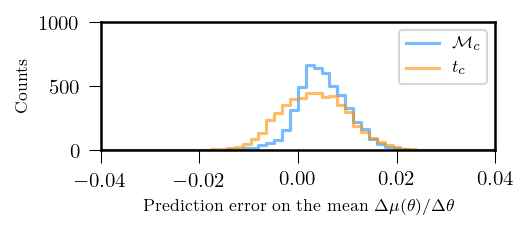

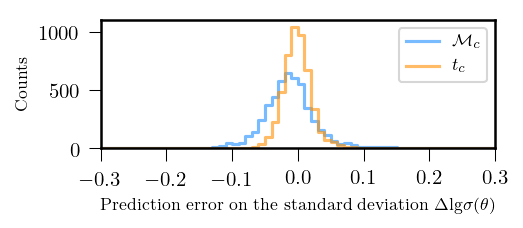

In [335]:
import matplotlib.pyplot as pp
pp.figure(figsize=(fig_width, fig_width/3))
pp.plot(bins1 , n1, alpha=0.6, color=dodgerblue, label='$\mathcal{M}_c$')
pp.plot(bins2, n2, alpha=0.6, color=princetonorange, label='$t_c$')
pp.xlabel(r'Prediction error on the mean $\Delta\mu(\theta) / \Delta\theta$')
pp.ylabel('Counts')
pp.legend()
#pp.minorticks_on()
pp.xlim(-0.04, 0.04)
pp.ylim(0, 1000)
pp.show()
pp.figure(figsize=(fig_width, fig_width/3))
pp.plot(bins11, n11, alpha=0.6, color=dodgerblue, label='$\mathcal{M}_c$')
pp.plot(bins12, n12, alpha=0.6, color=princetonorange, label='$t_c$')
pp.xlabel(r'Prediction error on the standard deviation $\Delta$lg$ \sigma(\theta)$')
pp.ylabel('Counts')
pp.legend()
pp.xlim(-0.3, 0.3)
pp.ylim(0,1100)
pp.show()

# MID SPIN

In [40]:
rd_dist1 = nm22[idx2, 0] - lm22[idx2, 0]
rd_dist2 = nm22[idx2, 1] - lm22[idx2, 1]
rd_stderr1 = np.log(ne22[idx2,0]) - np.log(le22[idx2,0])
rd_stderr2 = np.log(ne22[idx2,1]) - np.log(le22[idx2,1])

bins3, n3 = histOutline(rd_dist1, bins=50)#, range=range2)
bins4, n4 = histOutline(rd_dist2, bins=50)#, range=range2)
bins33, n33 = histOutline(rd_stderr1, bins=50)
bins44, n44 = histOutline(rd_stderr2, bins=50)

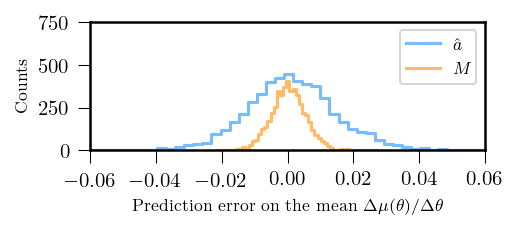

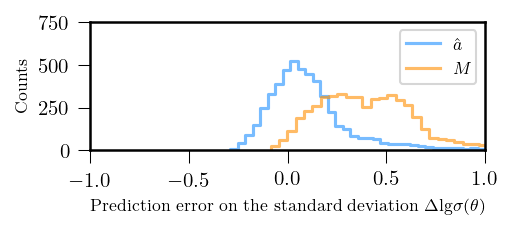

In [41]:
pp.figure(figsize=(fig_width, fig_width/3))
pp.plot(bins3, n3, alpha=0.6, color=dodgerblue, label='$\hat{a}$')
pp.plot(bins4, n4, alpha=0.6, color=princetonorange, label='$M$')
pp.xlabel(r'Prediction error on the mean $\Delta\mu(\theta) / \Delta\theta$')
pp.ylabel('Counts')
pp.legend()
pp.xlim(-0.06, 0.06)
pp.ylim(0, 750)
pp.show()
pp.figure(figsize=(fig_width, fig_width/3))
pp.plot(bins33, n33, alpha=0.6, color=dodgerblue, label='$\hat{a}$')
pp.plot(bins44, n44, alpha=0.6, color=princetonorange, label='$M$')
pp.xlabel(r'Prediction error on the standard deviation $\Delta$lg$ \sigma(\theta)$')
pp.ylabel('Counts')
pp.legend()
pp.xlim(-1, 1)
pp.ylim(0,750)
pp.show()

# LOW SPIN

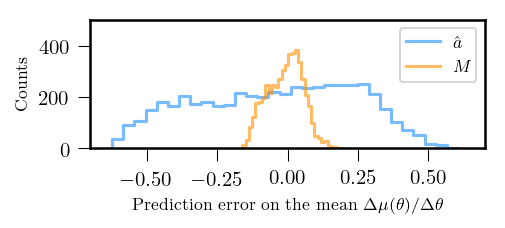

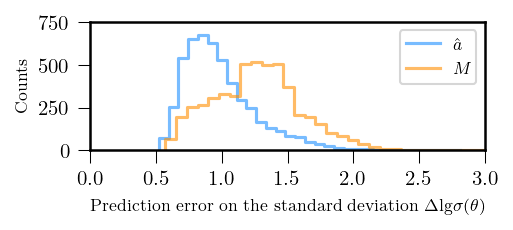

In [29]:
ls_dist1 = nm23[idx3, 0] - lm23[idx3, 0]
ls_dist2 = nm23[idx3, 1] - lm23[idx3, 1]
ls_stderr1 = np.log(ne23[idx3,0]) - np.log(le23[idx3,0])
ls_stderr2 = np.log(ne23[idx3,1]) - np.log(le23[idx3,1])

bins5, n5 = histOutline(ls_dist1, bins=30)#, range=range2)
bins6, n6 = histOutline(ls_dist2, bins=30)#, range=range2)
bins55, n55 = histOutline(ls_stderr1, bins=30)
bins66, n66 = histOutline(ls_stderr2, bins=30)
pp.figure(figsize=(fig_width, fig_width/3))
pp.plot(bins5, n5, alpha=0.6, color=dodgerblue, label='$\hat{a}$')
pp.plot(bins6, n6, alpha=0.6, color=princetonorange, label='$M$')
pp.xlabel(r'Prediction error on the mean $\Delta\mu(\theta) / \Delta\theta$')
pp.ylabel('Counts')
pp.legend()
pp.xlim(-0.7, 0.7)
pp.ylim(0, 500)
pp.show()
pp.figure(figsize=(fig_width, fig_width/3))
pp.plot(bins55, n55, alpha=0.6, color=dodgerblue, label='$\hat{a}$')
pp.plot(bins66, n66, alpha=0.6, color=princetonorange, label='$M$')
pp.xlabel(r'Prediction error on the standard deviation $\Delta$lg$ \sigma(\theta)$')
pp.ylabel('Counts')
pp.legend()
pp.xlim(0, 3)
pp.ylim(0,750)
pp.show()

# HIGH SPIN

In [31]:
hs_dist1 = nm24[idx4, 0] - lm24[idx4, 0]
hs_dist2 = nm24[idx4, 1] - lm24[idx4, 1]
hs_stderr1 = np.log(ne24[idx,0]) - np.log(le24[idx,0])
hs_stderr2 = np.log(ne24[idx,1]) - np.log(le24[idx,1])

#bins = np.linspace(-1, 1, 33)
#range2 = (-0.01,0.01)


bins7, n7 = histOutline(hs_dist1, bins=30, range=(min(hs_dist1), max(hs_dist1)))
bins8, n8 = histOutline(hs_dist2, bins=30, range=(min(hs_dist2), max(hs_dist2)))
bins77, n77 = histOutline(hs_stderr1, bins=30, range=(min(hs_stderr1), max(hs_stderr1)))
bins88, n88 = histOutline(hs_stderr2, bins=30, range=(min(hs_stderr2), max(hs_stderr2)))

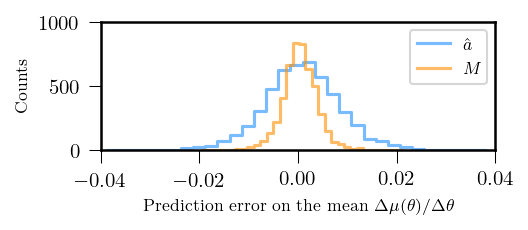

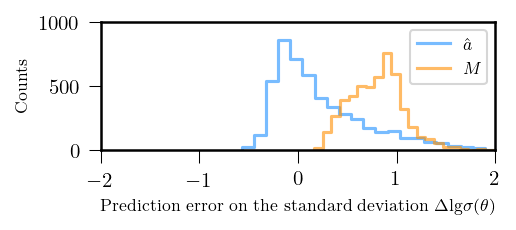

In [36]:
pp.figure(figsize=(fig_width, fig_width/3))
pp.plot(bins7, n7, alpha=0.6, color=dodgerblue, label='$\hat{a}$')
pp.plot(bins8, n8, alpha=0.6, color=princetonorange, label='$M$')
pp.xlabel(r'Prediction error on the mean $\Delta\mu(\theta) / \Delta\theta$')
pp.ylabel('Counts')
pp.legend()
pp.xlim(-0.04, 0.04)
pp.ylim(0, 1000)
pp.show()
pp.figure(figsize=(fig_width, fig_width/3))
pp.plot(bins77, n77, alpha=0.6, color=dodgerblue, label='$\hat{a}$')
pp.plot(bins88, n88, alpha=0.6, color=princetonorange, label='$M$')
pp.xlabel(r'Prediction error on the standard deviation $\Delta$lg$ \sigma(\theta)$')
pp.ylabel('Counts')
pp.legend()
pp.xlim(-2, 2)
pp.ylim(0,1000)
pp.show()

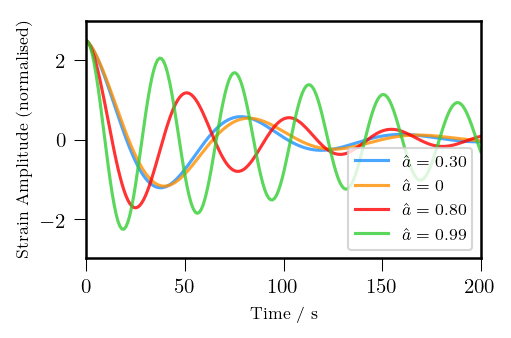

In [64]:
#model ringdown signal.
s1 = h_t((0.1, 5))
s2 = h_t((0, 5))
s3 = h_t((0.8, 5))
s4 = h_t((0.99, 5))
t=np.linspace(0,200,200)
pp.figure(figsize=fig_size)
pp.plot(t, s1, alpha=0.8, color=dodgerblue, label='$\hat{a}=0.30$')
pp.plot(t, s2, alpha=0.8, color=princetonorange, label='$\hat{a}=0$')
pp.plot(t, s3, alpha=0.8,  color='red', label='$\hat{a}=0.80$')
pp.plot(t, s4, alpha=0.8, color='limegreen', label='$\hat{a}=0.99$')
pp.ylim(-3,3)
pp.xlim(0, 200)
pp.xlabel('Time / s')
pp.ylabel('Strain Amplitude (normalised)')
pp.legend()
pp.show()

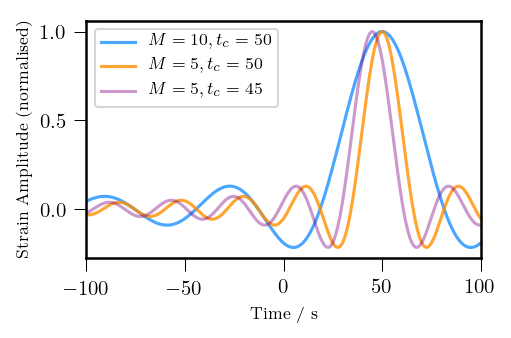

In [77]:
##sinc model signal
#model ringdown signal.
s5 = h_func_mt((10, 50))
s6 = h_func_mt((5, 50))
s7 = h_func_mt((5, 45))
t2=np.linspace(-100,100,200)
pp.figure(figsize=fig_size)
pp.plot(t2, s5, alpha=0.8, color=dodgerblue, label='$M=10, t_c=50$')
pp.plot(t2, s6, alpha=0.8, color=princetonorange, label='$M=5, t_c=50$')
pp.plot(t2, s7, alpha=0.4, color='purple', label='$M=5, t_c=45$')
#pp.ylim(-3,3)
pp.xlim(-100, 100)
pp.xlabel('Time / s')
pp.ylabel('Strain Amplitude (normalised)')
pp.legend()
pp.show()